In [1]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [2]:
dens=np.array([2.4,2.45,2.5,2.55,2.6,2.65,2.7,2.75,2.8,2.85,2.9,2.95,3,3.05,3.1,3.15,3.2,3.25,3.3,3.35,3.4])
flujo=[0.0128,0.0122,0.0116,0.0110,0.0105,0.0101,0.0096,0.0092,0.0088,0.0084,0.0081,0.0078,0.0075,0.0072,0.0069,0.0066,0.0064,0.0061,0.0059,0.0057,0.0055]
densi=[3.970,2.8,3.18,3.3,1.563,2.2,1.3,2.3,2.4,2.65,1.76]
dens1=np.array(densi)
den=np.sort(dens1)
stop_power=np.array([1.779,1.787,1.76,1.699,1.711,1.684,1.688,1.686,1.655,1.65,1.647])

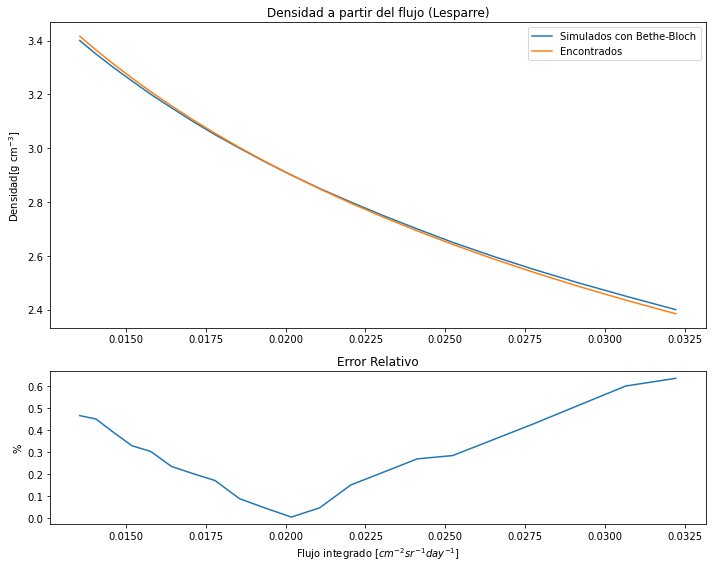

In [6]:
def new_flux(den):
    m_0 = 105.6583755  # Masa del muón en MeV/c^2
    m_e = 0.511
    c = 1  # Velocidad de la luz en cm/s
    rho = den  # Densidad de la roca estándar en g/cm^3
    I = 136e-6  # Energía de ionización en eV
    Z = 11  # Número atómico de la roca
    A = 22  # Número másico de la roca
    E_G=np.linspace(1,1e4,100000)
    E=E_G*1000
    beta = np.sqrt(1 - (m_0**2) / ((E+ m_0)**2))  # Calcular beta
    gamma = 1 / np.sqrt(1 - beta**2)  # Calcular gamma
    beta_sq = np.clip(beta**2, 1e-8, 1)
    # Constantes y fórmula de Bethe-Bloch ajustada
    K = 0.307075  # Constante de Bethe-Bloch (MeV cm^2 / g)
    argument_log = 2 * m_e * beta_sq * gamma**2 / I
    log_term = np.log(np.clip(argument_log, 1.01, np.inf))  # Clip para evitar log negativos
    delta = np.where(beta * gamma > 10, 0.10 * np.log10(beta * gamma) - 0.4, 0)
    stopping_power = K * (Z / A) * (1 / beta_sq) * (log_term/2 - beta_sq)
    a = 0.0022
    b = 0.85e-6
    rad= b * E
    stop=stopping_power
    
    emin=E_G[np.argmin((rho*400.691*1e2 - (E/(stop)))**2)] - m_0/1e3
    #print(((emin)))
    N=len(E_G)
    dE_0=(1e4-1e0)/N        
    cenith = 76.656
    theta = cenith*np.pi/180.0 # cenith angle / redians
    
    m0 = 0.1056 
    p = np.sqrt((E_G**2-m0**2*c**4)/c**2) 

    y = np.log10(p*np.cos(theta)) 
    AB = 0.00253
    a0 = 0.2455
    a1 = 1.288
    a2 = -0.2555
    a3 = 0.0209
    Int_flux=0
    Phi_Bugaev_Reyna = AB*(p**(-(a3*y**3 + a2*y**2 + a1*y + a0)))*(np.cos(theta))**3
    for i in range(N):
        if E_G[i] >= emin:
            Int_flux = Int_flux + Phi_Bugaev_Reyna[i] 
    Int_flux = Int_flux*dE_0
    flu=Int_flux*86400
    #plt.loglog(E_G,(rho*400.691*1e2 - (E/(stop)))**2)
    
    return flu


flu=[]
for i in range(len(dens)):
    flu.append(new_flux(dens[i]))
flu=np.array(flu)
new_den=[]

for i in range(len(dens)):
    new_den.append(densidad(flu[i]/2.5,76.656,400.691))
new_den=np.array(new_den)
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})
axs[0].plot(flu,dens,label="Simulados con Bethe-Bloch")
axs[0].plot(flu,new_den,label="Encontrados")
axs[1].set_xlabel("Flujo integrado [$cm^{-2}sr^{-1}day^{-1}$]")
axs[0].set_ylabel("Densidad[g cm$^{-3}$]")
axs[0].set_title("Densidad a partir del flujo (Lesparre)")
axs[0].legend()
error_rel=(np.abs(dens-new_den))/dens*100
axs[1].plot(flu, error_rel)
axs[1].set_title("Error Relativo")
axs[1].set_ylabel("%")
plt.tight_layout()
plt.show()

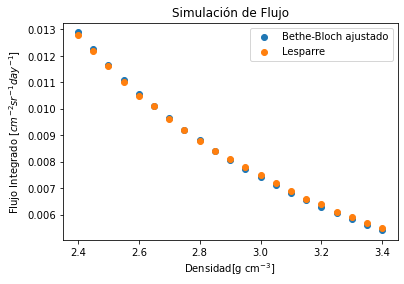

In [4]:
plt.scatter(dens,flu/2.5,label="Bethe-Bloch ajustado")
plt.scatter(dens,flujo,label="Lesparre")
plt.title("Simulación de Flujo")
plt.legend()
plt.ylabel("Flujo Integrado [$cm^{-2}sr^{-1}day^{-1}$]")
plt.xlabel("Densidad[g cm$^{-3}$]")
plt.show()

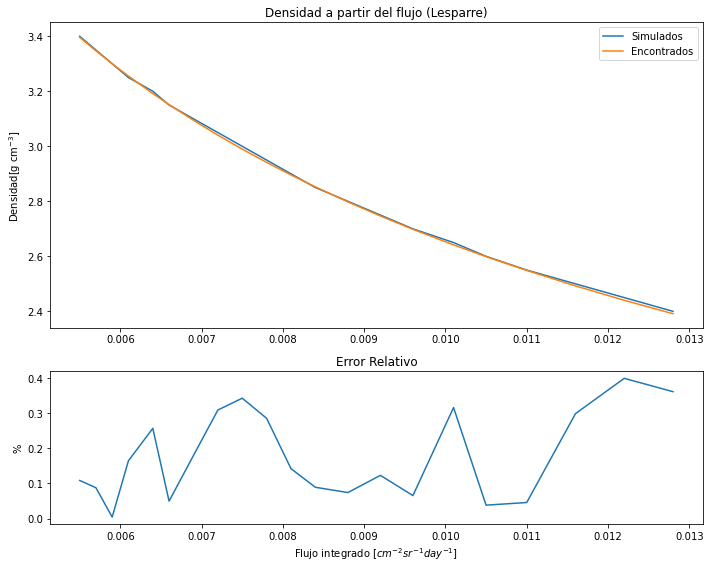

In [5]:
def densidad(flujo,cenit,lm):
    E=np.linspace(1e0,1e4,1000000)
    M = 1000000
    dE = (1e4-1e0)/M
    flujo1=flujo*(1/(86400*dE))
    m0 = 0.1056
    c = 1
    p = np.sqrt((E**2-m0**2*c**4)/c**2) 
    theta=cenit*np.pi/180
    y = np.log10(p*np.cos(theta)) 
    AB = 0.00253
    a0 = 0.2455
    a1 = 1.288
    a2 = -0.2555
    a3 = 0.0209
    
    
    Phi_Bugaev_Reyna = AB*(p**(-(a3*y**3 + a2*y**2 + a1*y + a0)))*(np.cos(theta))**3
    N=len(Phi_Bugaev_Reyna)
    Emin=0
    
    while flujo1>0:
        for i in range(N):
            flujo1=flujo1-Phi_Bugaev_Reyna[N-i-1]
            if flujo1<=0:
                Emin=N-i-1
                break
    y = np.log10(E)
    l0 = 0.2549
    l1 = 0.0801
    l2 = 0.0368
    l3 = -0.0461
    l4 = 0.0154
    dEdp = -10**((l4*y**3.65) + (l3*y**3)  + (l2*y**2) + l1*y + l0)
    Eu = 105.6
    rho=(E[Emin]-Eu/1e3)/(-dEdp[Emin]*(lm*1e2)/1e3)
    return rho
N=len(flujo)
resultado=np.zeros(N)
for i in range(N):
    resultado[i]=(densidad(flujo[i],76.656,400.691))
np.abs((resultado-dens)/dens)*100
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})
axs[0].plot(flujo,dens,label="Simulados")
axs[0].plot(flujo,resultado,label="Encontrados")
axs[1].set_xlabel("Flujo integrado [$cm^{-2}sr^{-1}day^{-1}$]")
axs[0].set_ylabel("Densidad[g cm$^{-3}$]")
axs[0].set_title("Densidad a partir del flujo (Lesparre)")
axs[0].legend()
error_rel=(np.abs(dens-resultado))/dens*100
axs[1].plot(flujo, error_rel)
axs[1].set_title("Error Relativo")
axs[1].set_ylabel("%")
plt.tight_layout()
plt.show()

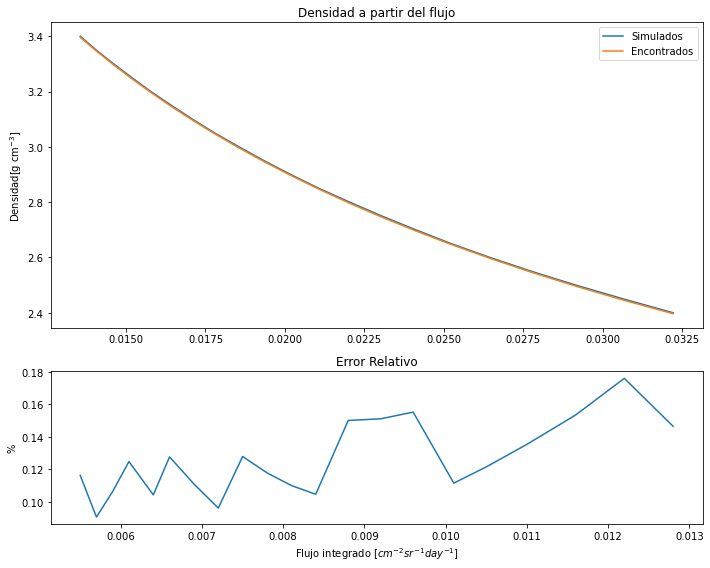

In [8]:
def nueva_densidad(flujo,cenit,lm):
    E=np.linspace(1e0,1e4,1000000)
    M = 1000000
    dE = (1e4-1e0)/M
    flujo1=flujo*(1/(86400*dE))
    m0 = 0.1056
    c = 1
    p = np.sqrt((E**2-m0**2*c**4)/c**2) 
    theta=cenit*np.pi/180
    y = np.log10(p*np.cos(theta)) 
    AB = 0.00253
    a0 = 0.2455
    a1 = 1.288
    a2 = -0.2555
    a3 = 0.0209
    
    
    Phi_Bugaev_Reyna = AB*(p**(-(a3*y**3 + a2*y**2 + a1*y + a0)))*(np.cos(theta))**3
    N=len(Phi_Bugaev_Reyna)
    Emin=0
    
    while flujo1>0:
        for i in range(N):
            flujo1=flujo1-Phi_Bugaev_Reyna[N-i-1]
            if flujo1<=0:
                Emin=N-i-1
                break
    m_0 = 105.6583755  # Masa del muón en MeV/c^2
    m_e = 0.511
    c = 1  # Velocidad de la luz en cm/s
    rho = den  # Densidad de la roca estándar en g/cm^3
    I = 136e-6  # Energía de ionización en eV
    Z = 11  # Número atómico de la roca
    A = 22  # Número másico de la roca
    E_G=np.linspace(1,1e4,1000000)
    E=E_G*1000
    beta = np.sqrt(1 - (m_0**2) / ((E+ m_0)**2))  # Calcular beta
    gamma = 1 / np.sqrt(1 - beta**2)  # Calcular gamma
    beta_sq = np.clip(beta**2, 1e-8, 1)
    # Constantes y fórmula de Bethe-Bloch ajustada
    K = 0.307075  # Constante de Bethe-Bloch (MeV cm^2 / g)
    argument_log = 2 * m_e * beta_sq * gamma**2 / I
    log_term = np.log(np.clip(argument_log, 1.01, np.inf))  # Clip para evitar log negativos
    delta = np.where(beta * gamma > 10, 0.10 * np.log10(beta * gamma) - 0.4, 0)
    stopping_power = K * (Z / A) * (1 / beta_sq) * (log_term/2 - beta_sq)
    a = 0.0022
    b = 0.85e-6
    rad= b * E
    stop=stopping_power
    Eu = 105.6
    rho=(E_G[Emin]-Eu/1e3)/(stop[Emin]*(lm*1e2)/1e3)
    return rho
N=len(flu)
resultado=np.zeros(N)
for i in range(N):
    resultado[i]=(nueva_densidad(flu[i],76.656,400.691))
np.abs((resultado-dens)/dens)*100
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})
axs[0].plot(flu,dens,label="Simulados")
axs[0].plot(flu,resultado,label="Encontrados")
axs[1].set_xlabel("Flujo integrado [$cm^{-2}sr^{-1}day^{-1}$]")
axs[0].set_ylabel("Densidad[g cm$^{-3}$]")
axs[0].set_title("Densidad a partir del flujo")
axs[0].legend()
error_rel=(np.abs(dens-resultado))/dens*100
axs[1].plot(flujo, error_rel)
axs[1].set_title("Error Relativo")
axs[1].set_ylabel("%")
plt.tight_layout()
plt.show()

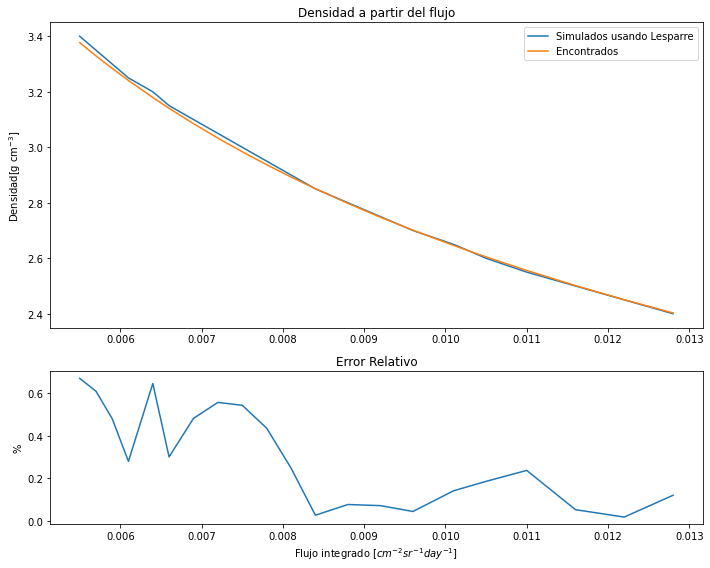

In [9]:
N=len(flujo)
resultado=np.zeros(N)
for i in range(N):
    resultado[i]=(nueva_densidad(flujo[i]*2.5,76.656,400.691))
np.abs((resultado-dens)/dens)*100
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})
axs[0].plot(flujo,dens,label="Simulados usando Lesparre")
axs[0].plot(flujo,resultado,label="Encontrados")
axs[1].set_xlabel("Flujo integrado [$cm^{-2}sr^{-1}day^{-1}$]")
axs[0].set_ylabel("Densidad[g cm$^{-3}$]")
axs[0].set_title("Densidad a partir del flujo")
axs[0].legend()
error_rel=(np.abs(dens-resultado))/dens*100
axs[1].plot(flujo, error_rel)
axs[1].set_title("Error Relativo")
axs[1].set_ylabel("%")
plt.tight_layout()
plt.show()